<a href="https://colab.research.google.com/github/ParthikB/encryption/blob/master/encryption_digit_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  running = 'GPU'
else:
  device = torch.device('cpu')
  running = 'CPU'
print(f'Running on : {running}')

Running on : GPU


### Grabbing the Data

In [0]:
train = datasets.MNIST('', train=True, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))

test  = datasets.MNIST('', train=False, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))

## Creating the Dataset Tensor

In [0]:
BATCH_SIZE = 32
HEIGHT, WIDTH = 28, 28
TOTAL_PIXELS = HEIGHT*WIDTH

trainSet = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
testSet  = torch.utils.data.DataLoader(test,  batch_size=BATCH_SIZE, shuffle=True)

#### Viewing one Sample

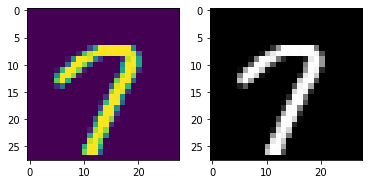

In [9]:
i = np.random.randint(BATCH_SIZE) # a random sample from the first batch
for data in trainSet:
    # data --> one batch containing BATCH_SIZE samples
    x, y = data[0][i], data[1][i]

plt.subplot(1, 2, 1)
plt.imshow(x.view(HEIGHT, WIDTH)) # Reshaping x from (1, Height, Width) --> (Height, Width)

plt.subplot(1, 2, 2)
plt.imshow(x.view(HEIGHT, WIDTH), cmap='gray')

## Creating the Network Structure

In [0]:
l2_size = TOTAL_PIXELS

class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(TOTAL_PIXELS, l2_size)
        self.fc2 = nn.Linear(l2_size, l2_size)        
        self.fc3 = nn.Linear(l2_size, TOTAL_PIXELS)        
    
    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x2 = F.sigmoid(self.fc2(x))        
        x = F.sigmoid(self.fc3(x2))        
        
        return x, x2

## Training the Network

  0%|          | 0/1875 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  1%|          | 20/1875 [00:00<00:09, 196.39it/s]

EPOCH : 1


  1%|▏         | 25/1875 [00:00<00:07, 239.21it/s]

EPOCH : 2


  1%|▏         | 26/1875 [00:00<00:07, 257.87it/s]

EPOCH : 3


  1%|          | 20/1875 [00:00<00:09, 195.27it/s]

EPOCH : 4


  1%|▏         | 25/1875 [00:00<00:07, 241.92it/s]

EPOCH : 5


100%|██████████| 1875/1875 [00:07<00:00, 237.86it/s]


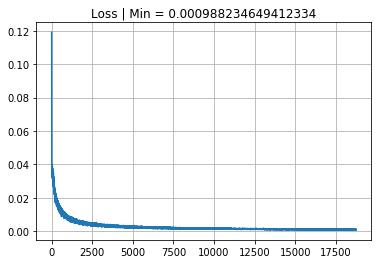

In [36]:
CONTINUE_TRAINING = False
LEARNING_RATE = 0.001 #1e-3
EPOCHS        = 10

if not CONTINUE_TRAINING:
  net = Net().to(device)

  # Define Optimizer
  optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

  loss_log = []

# Iteration Begins
for epoch in range(EPOCHS):
    print('EPOCH :', epoch+1)
    # Iterate over every sample in the batch
    for data in tqdm(trainSet):
        x, _ = data
        net.zero_grad()
        
        #Compute the output
        output, layer2 = net(x.view(-1, TOTAL_PIXELS).to(device))
        
        # Compute Loss
        loss = F.smooth_l1_loss(output, x.view(-1, TOTAL_PIXELS).to(device))
        loss_log.append(loss)
        
        # Backpropagate
        loss.backward()
        
        # Update Parameters
        optimizer.step()
        
    # print(loss)
plt.plot(loss_log)
plt.title(f'Loss | Min = {loss_log[-1].item()}')
plt.grid(1)

## Encryption Decryption

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Total Loss : 0.000988234649412334


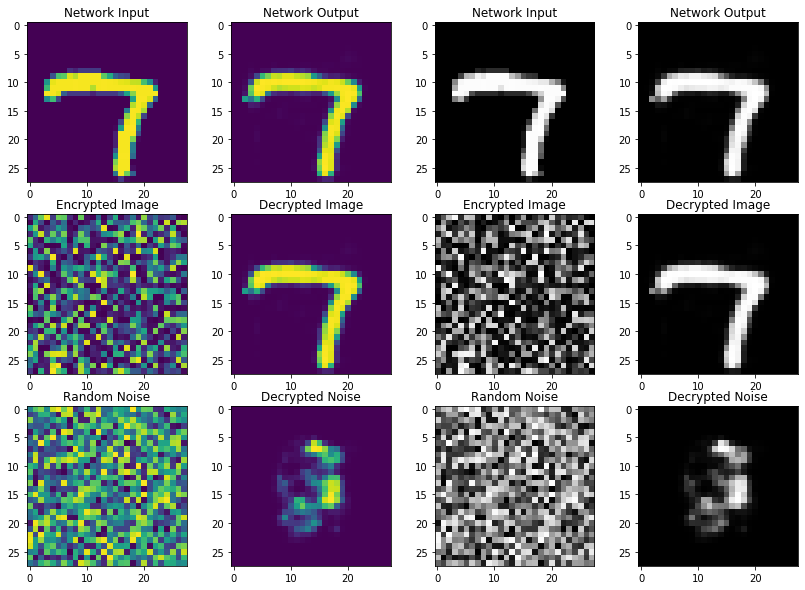

In [63]:
# Selecting a random sample from the dataset
random = np.random.randint(32)

for data in trainSet:
  # print(data)
  sample = data[0][random].view(HEIGHT, WIDTH)
  break


# Passing the sample through the Network and also generating the ENCYPTED IMAGE
with torch.no_grad():
    # for data in trainSet:
        x = sample
        testOutput, encryptedImage = net(x.view(-1, TOTAL_PIXELS).to(device))


# Converting the tensor into numpy array and reshaping from VECTOR to 2D MATRIX
# trainOutput = trainOutput.view(HEIGHT, WIDTH)
# trainOutput = trainOutput.detach().numpy()*255

testOutput  = testOutput.view(HEIGHT, WIDTH)
testOutput  = testOutput.cpu().detach().numpy()*255

encryptedImage  = encryptedImage.view(int(np.sqrt(l2_size)), int(np.sqrt(l2_size)))
randomNoise     = torch.rand(int(np.sqrt(l2_size)), int(np.sqrt(l2_size)))
# encryptedImage  = encryptedImage.cpu().detach().numpy()*255


# DECRYPTING THE IMAGE
with torch.no_grad():
  decryptedImage = F.sigmoid(net.fc3((torch.tensor(encryptedImage)).view(-1, l2_size)).to(device))
  randomNoiseDecrypted = F.sigmoid(net.fc3((randomNoise.view(-1, l2_size).to(device))))


encryptedImage = encryptedImage.cpu().detach().numpy()*255
decryptedImage = decryptedImage.view(HEIGHT, WIDTH).cpu().detach().numpy()*255
randomNoiseDecrypted = randomNoiseDecrypted.view(HEIGHT, WIDTH).cpu().detach().numpy()*255

# PLOTTING THE OUTPUTS
plt.figure(figsize=(14, 10))

plt.subplot(3, 4, 1)
plt.imshow(sample)
plt.title('Network Input')

plt.subplot(3, 4, 2)
plt.imshow(testOutput)
plt.title('Network Output')

plt.subplot(3, 4, 5)
plt.imshow(encryptedImage)
plt.title('Encrypted Image')

plt.subplot(3, 4, 6)
plt.imshow(decryptedImage)
plt.title('Decrypted Image')

plt.subplot(3, 4, 9)
plt.imshow(randomNoise)
plt.title('Random Noise')

plt.subplot(3, 4, 10)
plt.imshow(randomNoiseDecrypted)
plt.title('Decrypted Noise')

# The Original Gray Images
plt.subplot(3, 4, 3)
plt.imshow(sample, cmap='gray')
plt.title('Network Input')

plt.subplot(3, 4, 4)
plt.imshow(testOutput, cmap='gray')
plt.title('Network Output')

plt.subplot(3, 4, 7)
plt.imshow(encryptedImage, cmap='gray')
plt.title('Encrypted Image')

plt.subplot(3, 4, 8)
plt.imshow(decryptedImage, cmap='gray')
plt.title('Decrypted Image')

plt.subplot(3, 4, 11)
plt.imshow(randomNoise, cmap='gray')
plt.title('Random Noise')

plt.subplot(3, 4, 12)
plt.imshow(randomNoiseDecrypted, cmap='gray')
plt.title('Decrypted Noise')

print()
print("Total Loss :", loss_log[-1].item())